In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


In [2]:
df = pd.read_csv('/content/sample_data/student_feedback_100.csv')
print(df.head())
label_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df['sentiment'] = df['sentiment'].map(label_map)



                             feedback_text sentiment
0    I enjoyed the interactive activities.   neutral
1     The examples used were very helpful.  positive
2          The course was okay, not great.   neutral
3  The course content was well-structured.  positive
4  The course content was well-structured.  positive


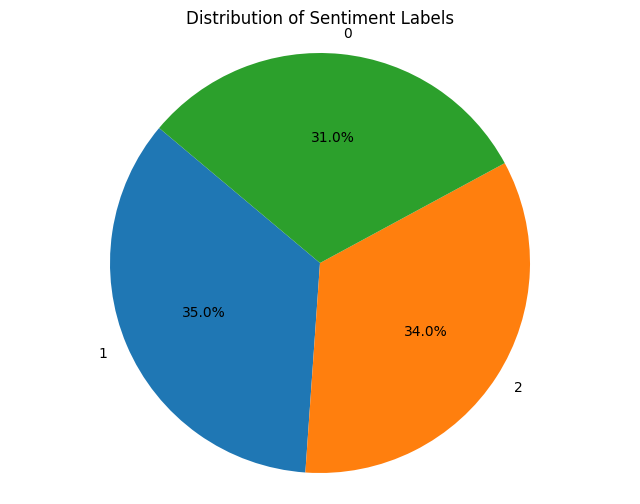

In [3]:
import matplotlib.pyplot as plt

# Count sentiment values
sentiment_counts = df['sentiment'].value_counts()

# Plot the pie chart using actual sentiment labels
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Labels')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
class FeedbackDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128)
        encoding['labels'] = torch.tensor(label)
        return {key: torch.tensor(val) for key, val in encoding.items()}


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['feedback_text'], df['sentiment'], test_size=0.2, random_state=42
)

train_dataset = FeedbackDataset(train_texts.tolist(), train_labels.tolist())
val_dataset = FeedbackDataset(val_texts.tolist(), val_labels.tolist())


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    run_name='bert-sentiment-analysis'
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


In [ ]:
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


<ipython-input-17-08b5b26bb0af>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val) for key, val in encoding.items()}


Epoch,Training Loss,Validation Loss
1,No log,0.892491
2,No log,0.764533
3,No log,0.714028


<ipython-input-17-08b5b26bb0af>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val) for key, val in encoding.items()}


Evaluation Results: {'eval_loss': 0.7140284776687622, 'eval_runtime': 7.4213, 'eval_samples_per_second': 2.695, 'eval_steps_per_second': 0.269, 'epoch': 3.0}


In [ ]:
# Save Model and Tokenizer
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')
print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


In [ ]:
texts = [
    "The course was excellent and very informative.",
    "The lecture was boring and not helpful."
]

predicted_sentiments = predict_sentiment(texts)
for result in predicted_sentiments:
    print(result)


Text: The course was excellent and very informative. -> Predicted Sentiment: Positive
Text: The lecture was boring and not helpful. -> Predicted Sentiment: Negative
